# Jul 23rd, 2022 (Fig-2 OCs; combined; n=128)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 128
perc = 20
fig_dir = 'Fig2_OCs'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n128-p20/Fig2_OCs

## Prepare (128)

In [3]:
mice = Mice(nn)
num_k = None

## Get results

In [4]:
final_perm={4: 6, 5: 4, 6: 5}
final_perm = {
    i: final_perm.get(i, i)
    for i in range(7)
}

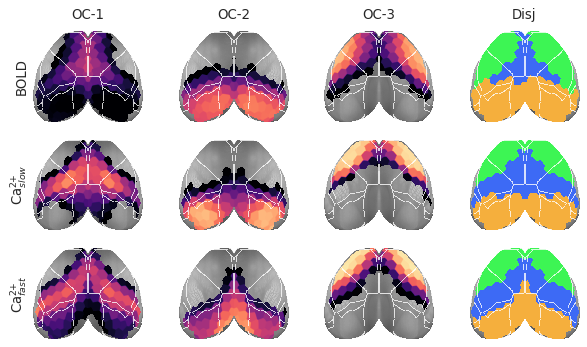

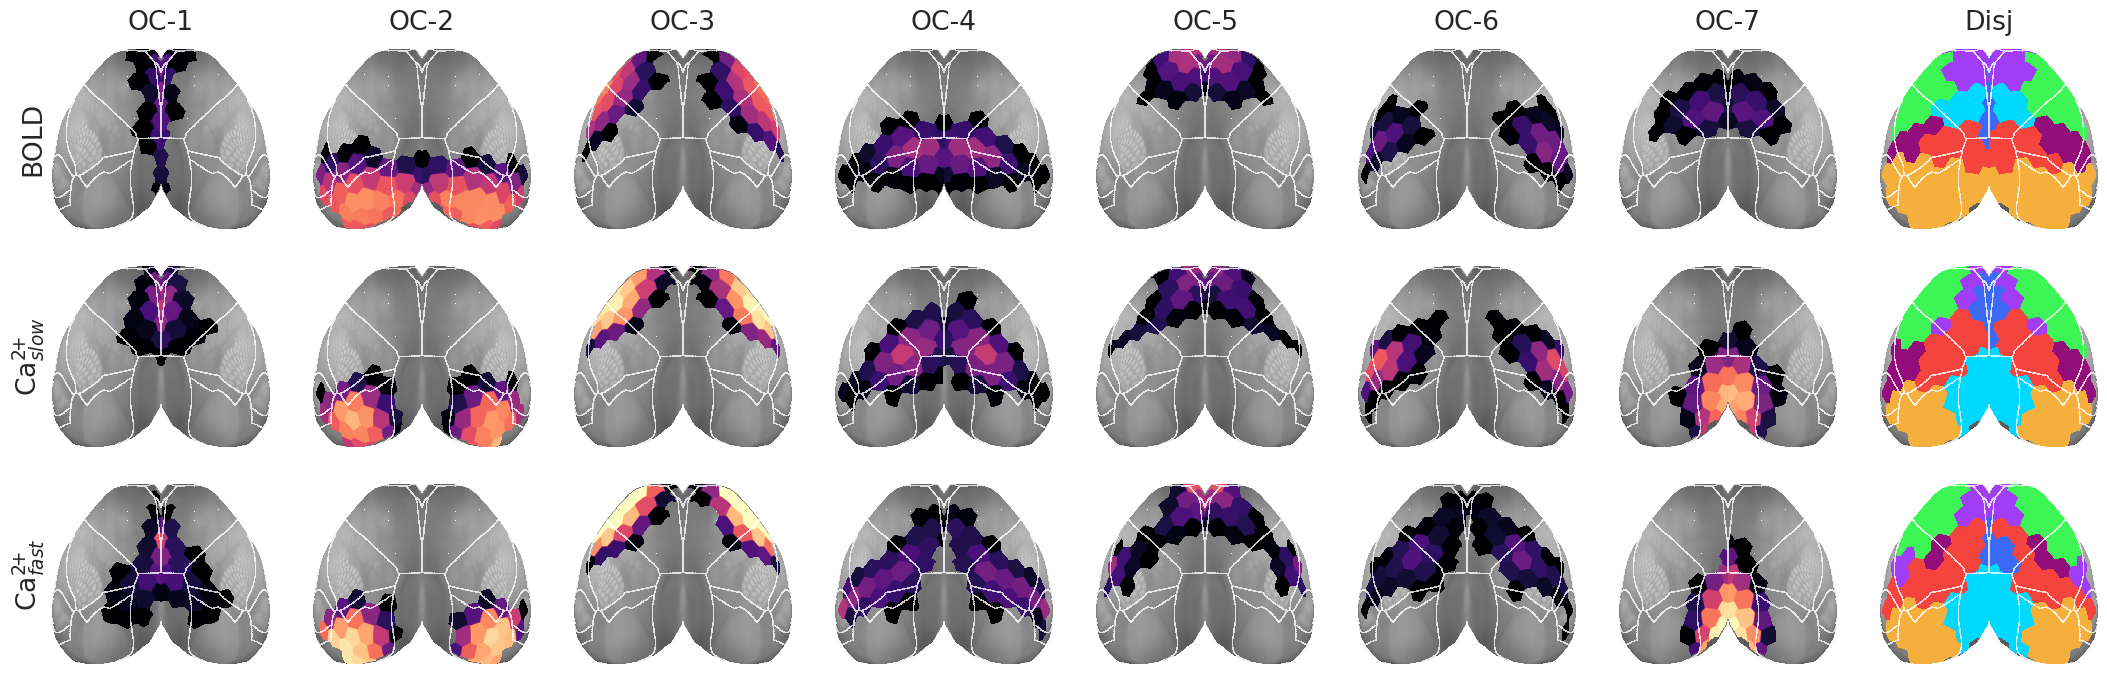

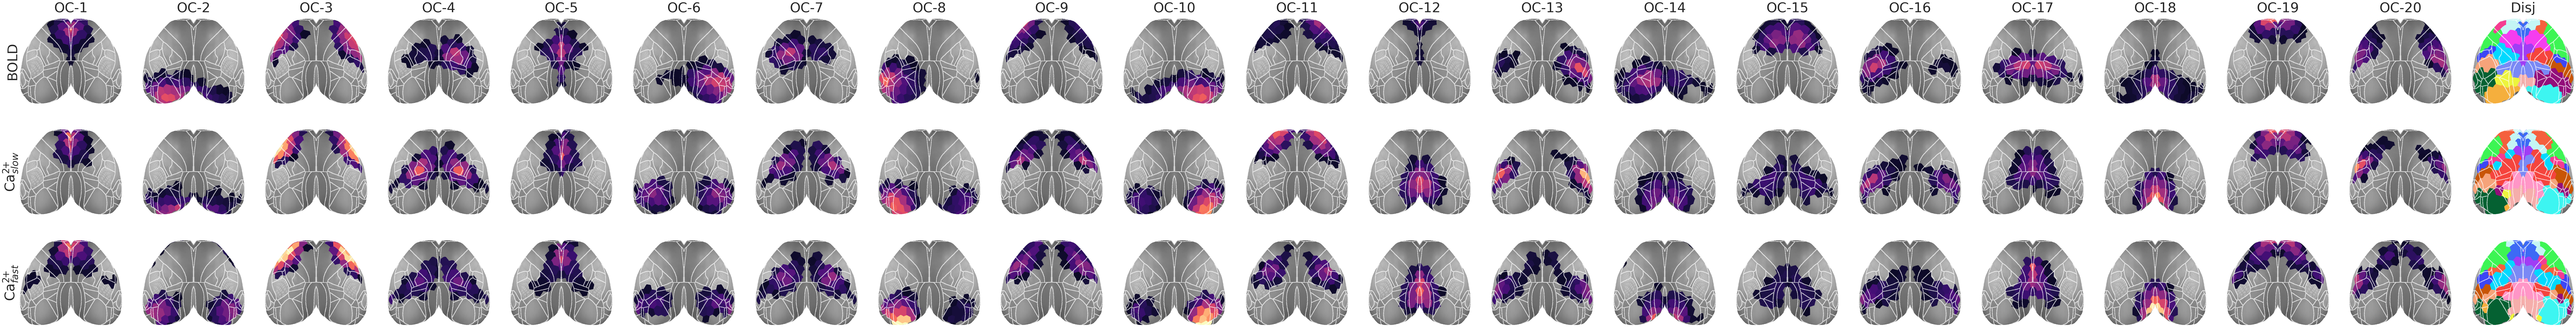

CPU times: user 1min 52s, sys: 11 s, total: 2min 3s
Wall time: 2min 3s


In [5]:
%%time

results = {}
for num_k in [3, 7, 20]:
    res = similiarity_results(
        mice=mice,
        perc=perc,
        num_k=num_k,
        n_resamples=int(1e3),
        merge_thres=0.376 if
        num_k == 7 else None,
        final_perm=final_perm if
        num_k == 7 else None,
    )
    results[num_k] = res

    bt = BootStrap(**res['props_ca'])
    _ = bt.show(res['pi_sorted'], **show_kws(num_k))

## Overall sim

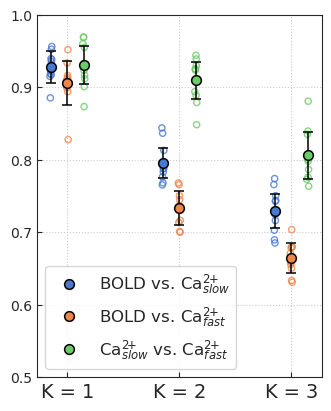

In [6]:
from figures.fig_ocs import similarity_point
fig, ax = similarity_point(results, True)

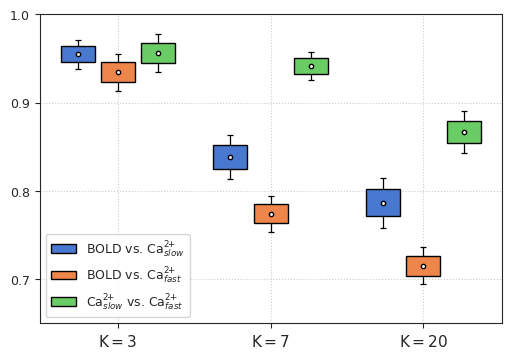

In [18]:
# from figures.fig_ocs import similarity_box as go
fig, _ = go(results, width=0.27, ylim=(0.65, 1.0))

fig.savefig(pjoin(fig_dir, 'sim_bx.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'sim_bx.png'), **kws_fig)

In [20]:
list(results[7])

[
    'bt_dict',
    'props_bo',
    'props_ca',
    'pi_sorted',
    'sim',
    'sim_b',
    'sim_overall',
    'sim_overall_b',
    'good_runs',
    'data4perm',
    'tests'
]

In [25]:
list(results[7]['sim_b'].values())[0].shape

(100, 7, 7)

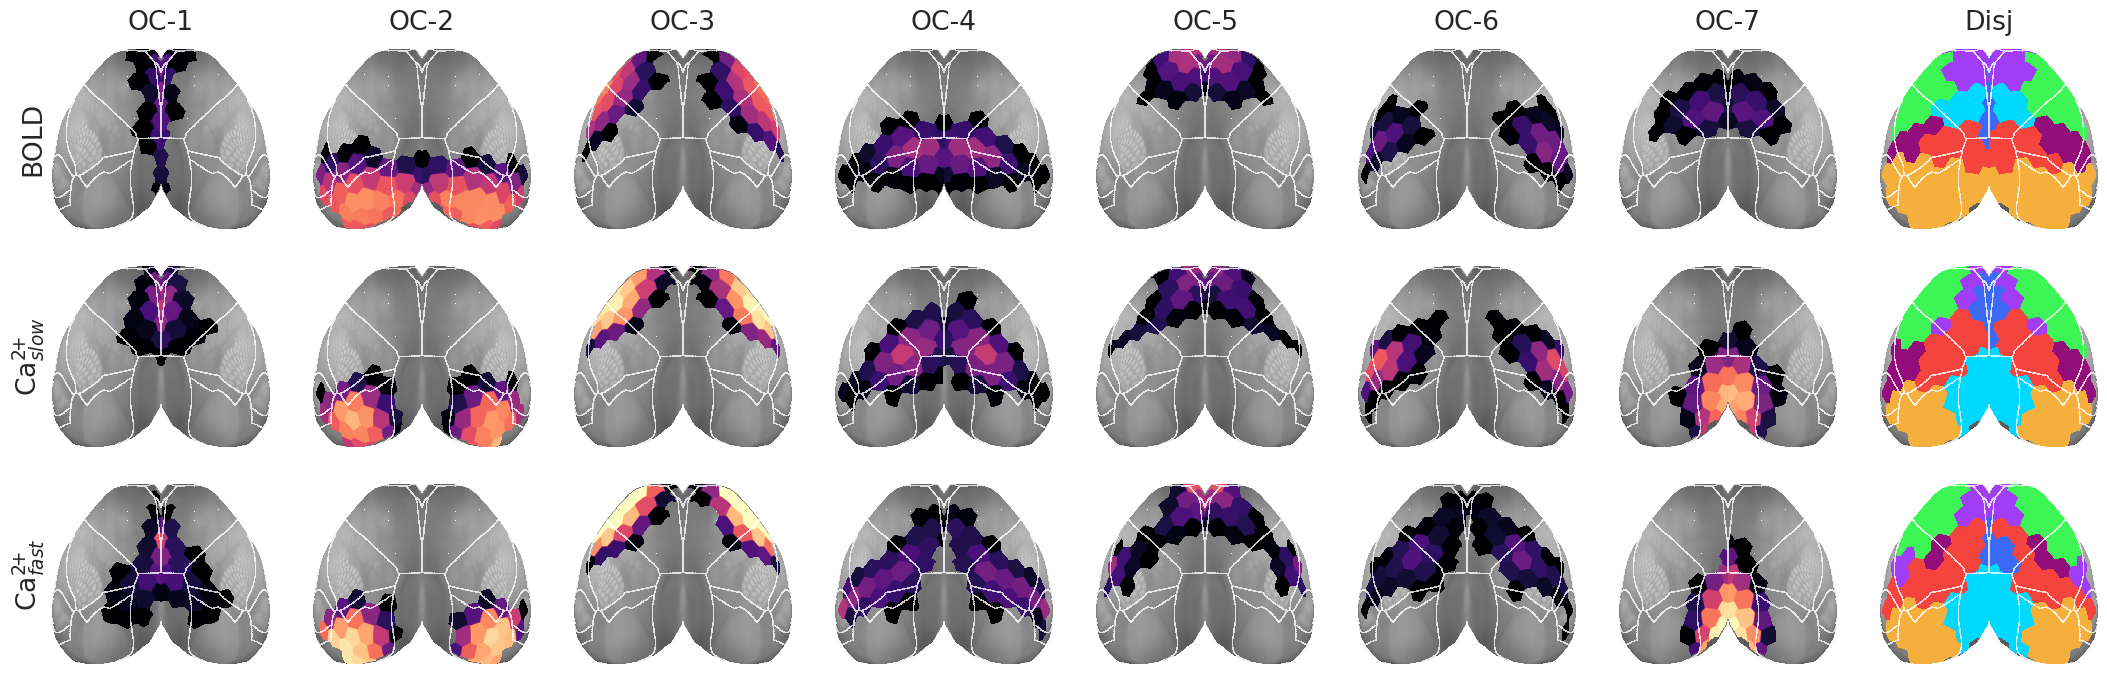

In [29]:
_ = bt.show(results[7]['pi_sorted'], **show_kws(7))

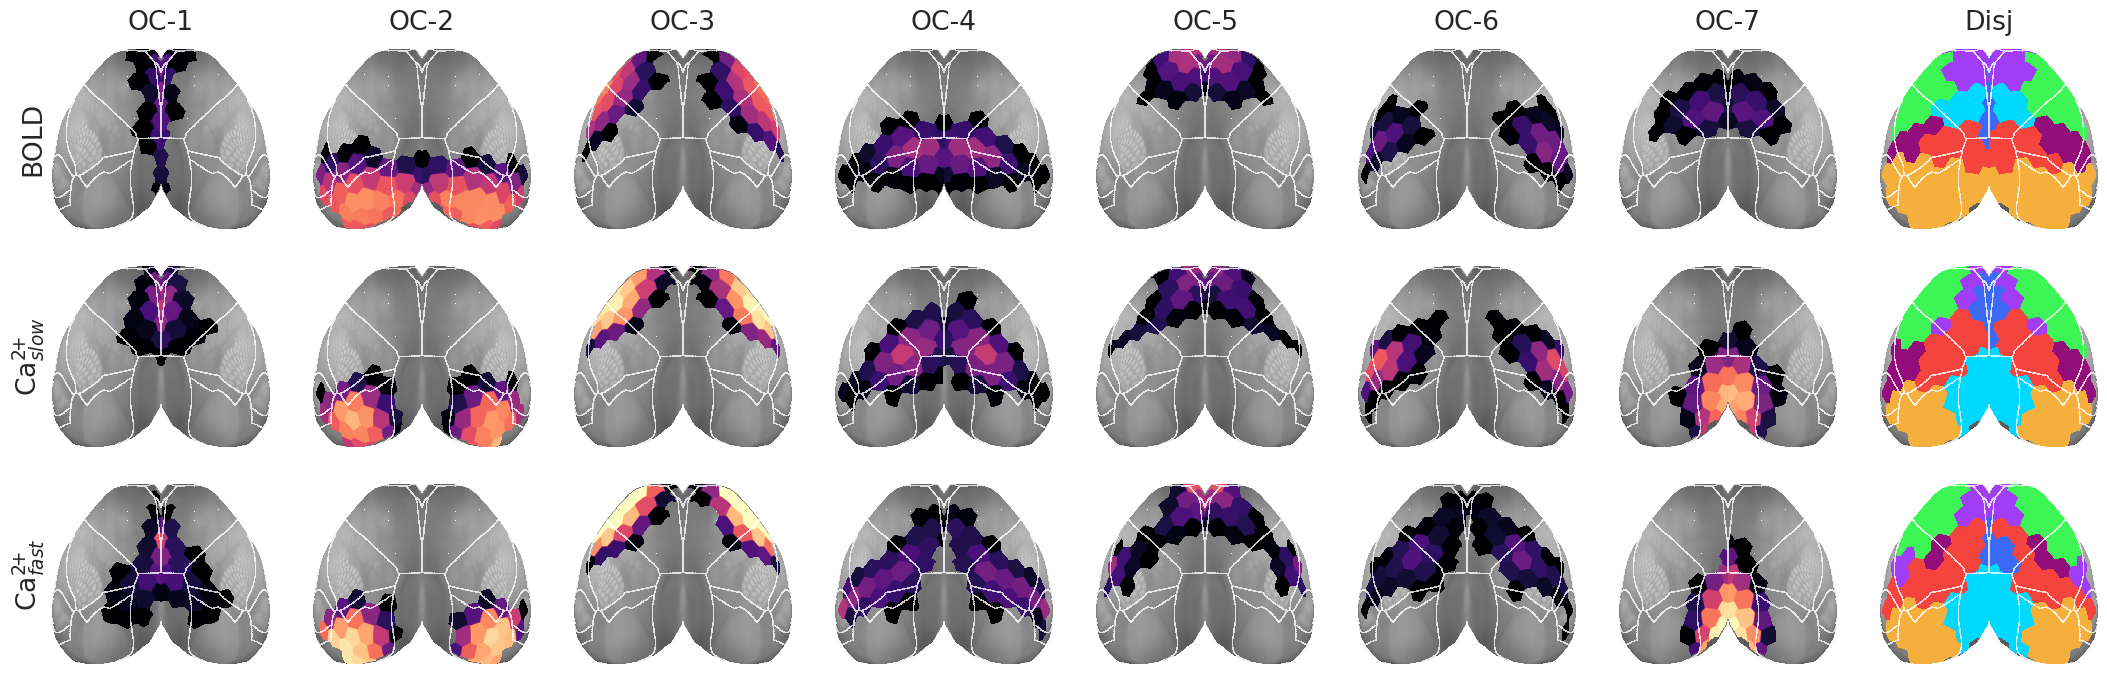

In [31]:
_ = bt.show({mode: avg(o.run_pi) for mode, o in results[7]['bt_dict'].items()}, **show_kws(7))

### Bar plot

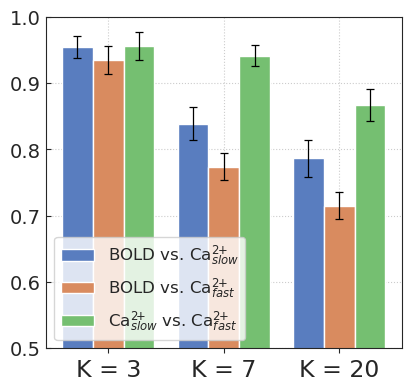

In [7]:
from figures.fig_ocs import similarity_bar as go
fig, _ = go(results, legend_fontsize=12)

fig.savefig(pjoin(fig_dir, 'sim_br.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'sim_br.png'), **kws_fig)

## FDR correction

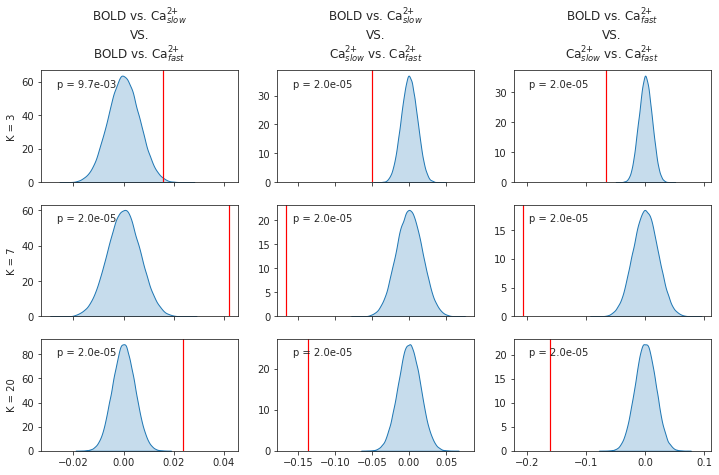

In [8]:
fig, axes = create_figure(3, 3, (12, 7), 'col')

for i, (num_k, res) in enumerate(results.items()):
    for j, (k, test) in enumerate(res['tests'].items()):
        ax = axes[i, j]
        sns.kdeplot(
            x=test.null_distribution,
            shade=True,
            ax=ax,
        )
        ax.axvline(test.statistic, color='r', ls='-', lw=1.2)
        ax.annotate(
            text=f"p = {test.pvalue:1.1e}",
            xycoords='axes fraction',
            xy=(0.08, 0.85),
        )
        if i == 0:
            ax.set_title(f"{k[0][0]} vs. {k[0][1]}\nVS.\n{k[1][0]} vs. {k[1][1]}", y=1.05)
        if j == 0:
            ax.set_ylabel(f'K = {num_k}')
        else:
            ax.set_ylabel('')
plt.show()

### Significance levels

In [9]:
pvals = {}
for num_k, res in results.items():
    for k, test in res['tests'].items():
        pvals[(num_k, ) + k] = test.pvalue

In [10]:
for alpha in [0.001, 0.01, 0.05]:
    reject, *_ = multipletests(
        pvals=list(pvals.values()),
        method='fdr_bh',
        alpha=alpha,
    )
    print(f"alpha = {alpha};  reject:\n{reject}")

alpha = 0.001;  reject:
[False  True  True  True  True  True  True  True  True]

alpha = 0.01;  reject:
[ True  True  True  True  True  True  True  True  True]

alpha = 0.05;  reject:
[ True  True  True  True  True  True  True  True  True]

## Bonferroni correction

### Significance levels

In [11]:
pvals = {}
for num_k, res in results.items():
    for k, test in res['tests'].items():
        pvals[(num_k, ) + k] = test.pvalue

In [12]:
for alpha in [0.001, 0.01, 0.05]:
    reject, *_ = multipletests(
        pvals=list(pvals.values()),
        method='bonferroni',
        alpha=alpha,
    )
    print(f"alpha = {alpha};  reject:\n{reject}")

alpha = 0.001;  reject:
[False  True  True  True  True  True  True  True  True]

alpha = 0.01;  reject:
[False  True  True  True  True  True  True  True  True]

alpha = 0.05;  reject:
[False  True  True  True  True  True  True  True  True]

In [13]:
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(
    pvals=list(pvals.values()),
    method='bonferroni',
    alpha=0.05,
)
print(f"alpha = {alpha};  reject:\n{reject}")

alpha = 0.05;  reject:
[False  True  True  True  True  True  True  True  True]

In [14]:
np.round(pvals_corrected, 3)

array([0.088, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [15]:
alphacBonf, 0.05 / 9

(0.005555555555555556, 0.005555555555555556)